In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data
We first load the training, test and validation datasets into a `tf.data.Dataset` helper to facilitate caching, prefetching and conversions. Our data consists of 13 classes: pawn, rook, bishop, knight, queen and king in both white and black (12 classes) plus one class for an empty square (no piece). The dataset consists of 2406 total images.

In [2]:

ds_train = image_dataset_from_directory(
    "../input/data-train/train",
    labels="inferred",
    label_mode="categorical",
    image_size=[224, 224],
    interpolation="nearest",
    batch_size=32,
    shuffle=True,
)

ds_test = image_dataset_from_directory(
    "../input/data-test/test",
    labels="inferred",
    label_mode="categorical",
    image_size=[224, 224],
    interpolation="nearest",
    batch_size=32,
    shuffle=True,
)

ds_val = image_dataset_from_directory(
    "../input/data-valid/valid",
    labels="inferred",
    label_mode="categorical",
    image_size=[224, 224],
    interpolation="nearest",
    batch_size=32,
    shuffle=False,
)

Found 1936 files belonging to 13 classes.
Found 234 files belonging to 13 classes.
Found 236 files belonging to 13 classes.


## Transform Data
Here, we use a `convert_to_float` helper function to convert the dataset from ints to floats for consistency and higher precision. We also use the `cache` function to load the images from memory after the first iteration for quicker training and improved performance. We also utilize tensorflow's `AUTOTUNE` macro to automate the buffer size for prefetching.

In [3]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
Our dataset is quite small, there are only roughly 2,000 training images. We will use a data augmentation technique to increase the number of images and improve our performance model. Here, we choose practical transformations that would result in realistic chess piece positions. For example, horizontal flipping, blurring, and random translations. We do not use rotations or vertical flips here, as it would not make sense for pieces to be upside down or heavily rotated.

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.5),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

## Transfer Learning
Typically during CNN model creation, we leverage the capabilities of a pre-trained model and enhance it with trainable convolution layers and the classification head. I will follow this model and leverage transfer learning on the pre-trained base **VGG16** model from Keras. We will include one Convolutional layer to train specifically on our dataset. Looking at the VGG16 model below, we can see it has 13 convolutional layers, 5 max pooling layers and 3 fully connected layers, trained on a total of 15 million images. This is likely to increase our performance substantially.

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

model_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_base.trainable = False
model_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Model Head
Now, we can define our model head which will bne trained on our data. I define the following architecture:
- A data augmentation layer to generate transformed images to prevent overfitting
- The VGG16 base model which is not trainable

- A 2D Convolutional layer to be trained on our dataset (includes batch normalization to reduce training time)

- A Global max pooling layer to flatten the outputs before feeding to the classification head

- A fully connected Dense layer of 128 neurons
- A dropout layer to prevent overfitting
- A final Dense layer with a softmax activation to classify into one of the 13 classes

In [6]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    data_augmentation,
    model_base,
    
    layers.BatchNormalization(),
    
    # conv layer 1
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # conv layer 2
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),

    # Output
    layers.Dense(13, activation='softmax'),
])

## Early Stopping
To prevent overfitting of our model, we define an early stopping callback. This is helpful to stop the model early when the validation loss is not decreasing anymore. We select `min_delta=0.001` as the threshold for imporvement, and we define `patience=20` to stop the model when there is no more deterioration in loss after 20 epochs.

## Optimizer and Loss Function
We choose the Adam optimizer as an adaptive gradient descent method which is the standard for computer vision tasks and performs well. We also select Categorical Cross Entropy as our loss function, since we have more than 2 categories (so binary cross entropy does not work here).

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

# compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

In [8]:
history = model.fit(
    ds_train,
    epochs=300,
    validation_data=ds_val,
    callbacks=[early_stopping],
)

Epoch 1/300
61/61 [==============================] - 24s 223ms/step - loss: 3.7815 - accuracy: 0.3533 - val_loss: 1.5855 - val_accuracy: 0.4322
Epoch 2/300
61/61 [==============================] - 8s 139ms/step - loss: 1.6254 - accuracy: 0.6064 - val_loss: 0.9351 - val_accuracy: 0.7034
Epoch 3/300
61/61 [==============================] - 9s 140ms/step - loss: 1.1168 - accuracy: 0.7278 - val_loss: 0.6857 - val_accuracy: 0.7627
Epoch 4/300
61/61 [==============================] - 9s 142ms/step - loss: 0.7809 - accuracy: 0.7918 - val_loss: 0.6072 - val_accuracy: 0.8008
Epoch 5/300
61/61 [==============================] - 9s 144ms/step - loss: 0.6645 - accuracy: 0.8171 - val_loss: 0.4370 - val_accuracy: 0.8602
Epoch 6/300
61/61 [==============================] - 9s 147ms/step - loss: 0.5728 - accuracy: 0.8445 - val_loss: 0.4263 - val_accuracy: 0.8814
Epoch 7/300
61/61 [==============================] - 9s 148ms/step - loss: 0.4443 - accuracy: 0.8760 - val_loss: 0.3548 - val_accuracy: 0.923

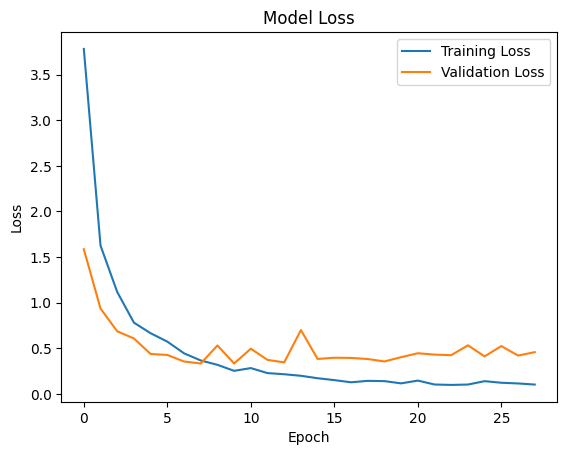

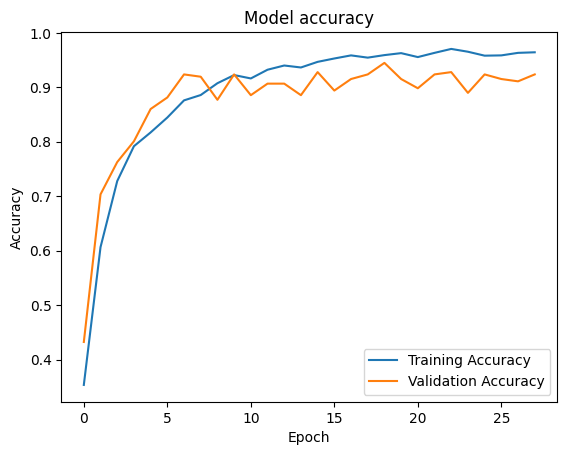

In [9]:
import pandas as pd

history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Validation Loss"])

history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Confusion Matrix and F1 Score
We will now plot a confusion matrix of the model's predictions to visualize the performance of our model on the test dataset.

In [10]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def labels_from_dataset(dataset: tf.data.Dataset, batched: bool = False):
    labels = list(map(lambda x: x[1], dataset))
    return tf.concat(labels, axis=0)

labels = labels_from_dataset(ds_test)
predictions = model.predict(ds_test)

y_predictions = np.argmax(predictions, axis=1)
y_true = np.argmax(labels, axis=1)

conf_matrix = confusion_matrix(y_predictions, y_true)

print(conf_matrix)

8/8 [==============================] - 3s 412ms/step
[[20  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  1  0  0  0  0  1  0  0  0]
 [ 0  0  0 18  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  2  1  4  0  1]
 [ 0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  1 19  0]
 [ 0  0  0  0  0  0  0  1  0  0  1  0 20]]


[Text(0, 0.5, 'bb'),
 Text(0, 1.5, 'bk'),
 Text(0, 2.5, 'bn'),
 Text(0, 3.5, 'bp'),
 Text(0, 4.5, 'bq'),
 Text(0, 5.5, 'br'),
 Text(0, 6.5, 'empty'),
 Text(0, 7.5, 'wb'),
 Text(0, 8.5, 'wk'),
 Text(0, 9.5, 'wn'),
 Text(0, 10.5, 'wp'),
 Text(0, 11.5, 'wq'),
 Text(0, 12.5, 'wr')]

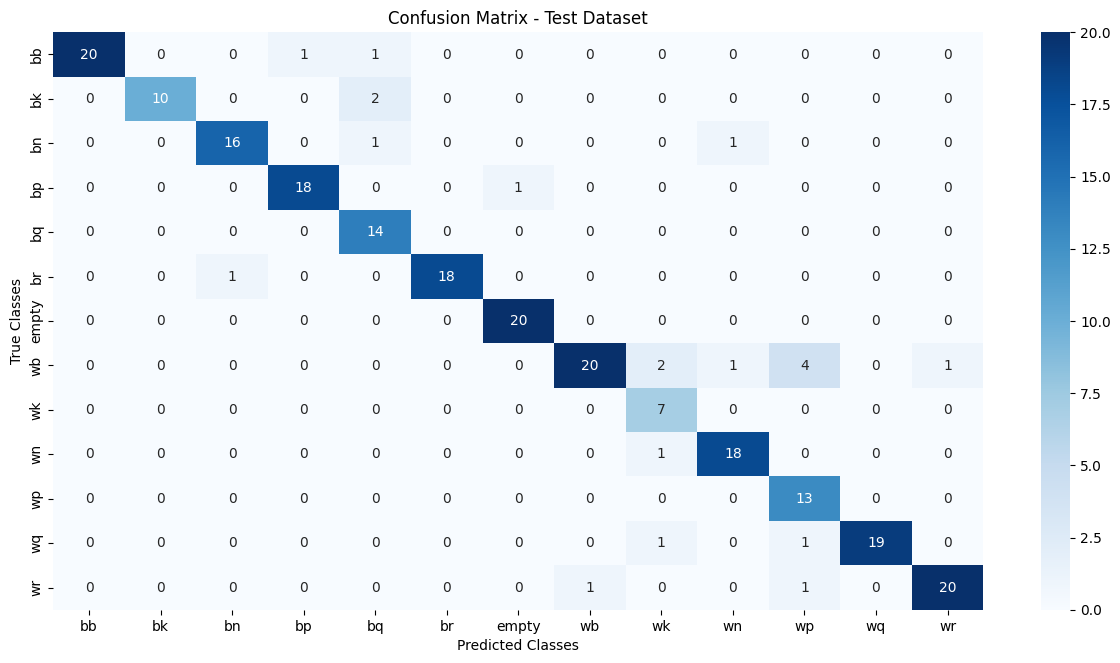

In [11]:
# plot with seaborn
class_names = ['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]

plt.figure(figsize=(15, 7.5))
ax = plt.subplot()
sns.heatmap(conf_matrix, cmap="Blues", annot=True, ax=ax)

ax.set_xlabel("Predicted Classes")
ax.set_ylabel("True Classes")
ax.set_title("Confusion Matrix - Test Dataset")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tabulate import tabulate

report = classification_report(
    y_true, y_predictions,
    target_names=class_names,
    digits=3
)

# show nice table with tabulate
report_data = []
lines = report.split('\n')
for line in lines[2:-3]:
    row = line.split()
    report_data.append(row)

table = tabulate(report_data, headers=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'], tablefmt='grid')
print(table)

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
+==========+=============+==========+============+===========+
| bb       |       0.909 |    1     |      0.952 |        20 |
+----------+-------------+----------+------------+-----------+
| bk       |       0.833 |    1     |      0.909 |        10 |
+----------+-------------+----------+------------+-----------+
| bn       |       0.889 |    0.941 |      0.914 |        17 |
+----------+-------------+----------+------------+-----------+
| bp       |       0.947 |    0.947 |      0.947 |        19 |
+----------+-------------+----------+------------+-----------+
| bq       |       1     |    0.778 |      0.875 |        18 |
+----------+-------------+----------+------------+-----------+
| br       |       0.947 |    1     |      0.973 |        18 |
+----------+-------------+----------+------------+-----------+
| empty    |       1     |    0.952 |      0.976 |     

In [13]:
accuracy = accuracy_score(y_true, y_predictions)
print(f"Total Accuracy: {accuracy}")

Total Accuracy: 0.9102564102564102


## Evaluating Performance
The classifier seems to perform well across most classes, with high precision, recall, and F1-scores for many classes.

Some classes, such as 'wb', 'wk', and 'wp', show slightly lower scores, indicating potential challenges in correctly classifying these instances.

The overall accuracy is 91.9%, suggesting that the model is effective in making correct predictions across all classes.

The macro and weighted averages are close to each other, indicating a balanced performance across different classes.

## TODO
Take a couple hundred pictures of chess pieces in real life and use my model on these pictures, to see how well it performs in the real world. 